# GAM Modelling - Beta Diversity

# 1. Package and libraries

In [68]:

library(sf)
library(dplyr)
library(ggplot2)
library(mgcv)
library(terra)
library(patchwork)
library(tidyr)
library(betapart)
library(vegan)
library(cluster)  # Para clustering y cálculo del índice de silhouette
library(factoextra)  # Para el método del codo y silhouette
library(NbClust)
library(raster)

# 2. Load data

In [69]:
grid_10_km = st_read( "Results/shp/grid_10km_samping_filter.shp")
dem_30m = rast("Data/raster/dem_30m.tif")
ecu = st_read("Data/Shp/ecuador_limits.shp")

insects_records = read.csv("Data/Records/insects_records_clean.csv")%>%
  filter(taxonRank == c("species"))

# Transform to sf object
insects_records_sf = st_as_sf(insects_records, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)

Reading layer `grid_10km_samping_filter' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Results\shp\grid_10km_samping_filter.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 198 features and 16 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -4.553896 xmax: -74.41422 ymax: 1.322877
Geodetic CRS:  WGS 84
Reading layer `ecuador_limits' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\ecuador_limits.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.01115 ymin: -5.016157 xmax: -75.18715 ymax: 1.453982
Geodetic CRS:  WGS 84


## 2.1. Extract DEM data

In [70]:
# Asegurar CRS igual
dem_30m <- project(dem_30m, st_crs(grid_10_km)$wkt)
grid_vect <- vect(grid_10_km)
# Extraer valores por celda del grid
ext_vals <- terra::extract(dem_30m, grid_vect)

# Calcular estadísticos por id
stats_elev <- ext_vals %>%
  group_by(ID) %>%
  summarise(
    elev_mean = mean(elevation, na.rm = TRUE)
  )
grid_10_km$ID = seq(1:dim(grid_10_km)[1])
grid_10km_elev <- grid_10_km %>%
  left_join(stats_elev, by = c("ID" = "ID"))
centroids <- st_centroid(grid_10km_elev)

# Extraer coordenadas como columnas X y Y
coords <- st_coordinates(centroids)

grid_10km_elev <- grid_10km_elev %>%
  mutate(
    centroid_x = coords[,1],
    centroid_y = coords[,2]
  )

head(grid_10km_elev)

Warning message:
st_centroid assumes attributes are constant over geometries 


Simple feature collection with 6 features and 20 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -3.741713 xmax: -80.14934 ymax: -0.9374151
Geodetic CRS:  WGS 84
    id     left     top    right  bottom id_10km Ttl_rcr Totl_sp Smplg_c
1  406 504459.9 9886386 514459.9 9876386     406      74      33  0.7038
2  505 514459.9 9816386 524459.9 9806386     505     109      61  0.5975
3  589 524459.9 9896386 534459.9 9886386     589     402      81  0.8882
4  595 524459.9 9836386 534459.9 9826386     595      51      25  0.6298
5 1056 574459.9 9826386 584459.9 9816386    1056     116      26  0.8622
6 1171 584459.9 9596386 594459.9 9586386    1171      82      18  0.9274
  n_rcrds sp_obs f1 f2    sc_ext n_rcrd_ sp_ext ID elev_mean
1      74     33 22  3 0.7752350     148     52  1  60.78743
2     109     61 44  7 0.7079283     218     99  2  24.95199
3     402     81 45 14 0.9400731     804    114  3  71.93604
4      51     25 19  3 0.7314652     102     4

# 3. Beta diversity

## 3.1. Presence/absence matrix

Recorcos inside high sampling coverage grids

In [71]:
insects_in_grid <- st_join(
  insects_records_sf,
  grid_10_km,
  join = st_within,
  left = FALSE        # Solo puntos dentro
)

# Extraer coordenadas a columnas X, Y
coords <- st_coordinates(insects_in_grid)

insects_in_grid_out <- insects_in_grid %>%
  mutate(
    centroid_x= coords[,1],
    centroid_y = coords[,2]
  ) %>%
  st_drop_geometry()   # Remover geometría si se quiere tabla pura

# Resultado final
print(head(insects_in_grid_out))


  id_record database_name database_id                         occurrenceID
2         4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb
3         6          BNDB  BNDB_10615 077e2a7f-7bd5-45fa-b755-c73a64708355
4         8          BNDB  BNDB_10617 431219fe-57b1-489b-aeba-cf5ea796076d
5        10          BNDB  BNDB_10619 51881f8d-794a-4847-9aa5-f67bfd4c110e
6        12          BNDB  BNDB_10622 6a39ade7-4d42-456e-b597-5f3f0f8bb09a
7        14          BNDB  BNDB_10624 b9a9b126-ddde-410e-8fbd-b2d202966e7e
      basisOfRecord verbatimEventDate identifiedBy
2 PreservedSpecimen        2015-07-04 Bonifacii R.
3 PreservedSpecimen        2015-07-04 Bonifacii R.
4 PreservedSpecimen        2015-07-04 Bonifacii R.
5 PreservedSpecimen        2015-10-30 Bonifacii R.
6 PreservedSpecimen        2015-07-04 Bonifacii R.
7 PreservedSpecimen        1987-08-17  Dressler R.
                                     recordedBy year institutionCode taxonRank
2                                  Boni

 Generate table

In [72]:

Table_presence= table(insects_in_grid_out$id_10km, insects_in_grid_out$scientificName) ### TABLA PARA ANALISIS BETA -D 

Table_presence[Table_presence>1]<-1

print(Table_presence[1:10,1:20])

      
       Abana horvathi Abanycha bicolor Abracris flavolineata Acanthacara acuta
  406               0                0                     0                 0
  505               0                0                     0                 0
  589               0                0                     0                 0
  595               0                0                     0                 0
  1056              0                0                     1                 0
  1171              0                0                     0                 0
  1214              0                0                     1                 0
  1223              0                0                     0                 0
  1246              0                0                     0                 0
  1255              0                0                     0                 0
      
       Acanthagrion apicale Acanthagrion cuyabae Acanthagrion lancea
  406                     0                    0

## 3.2. Jaccard metric

In [73]:
set.seed(593)
##### calculo de la beta diversidad 
betaDiv= beta.pair(Table_presence, index.family="jaccard") ## realiza los analisis de beta diversidad
## con el indice de jaccard ( presencia/ausencia), con particiones 


disimilarity= betaDiv$beta.jac

boxplot(disimilarity)

## 3.2. NMDS

Too long or NA distances: 8039 out of 19503 (41.2%)
Stepping across 19503 dissimilarities...


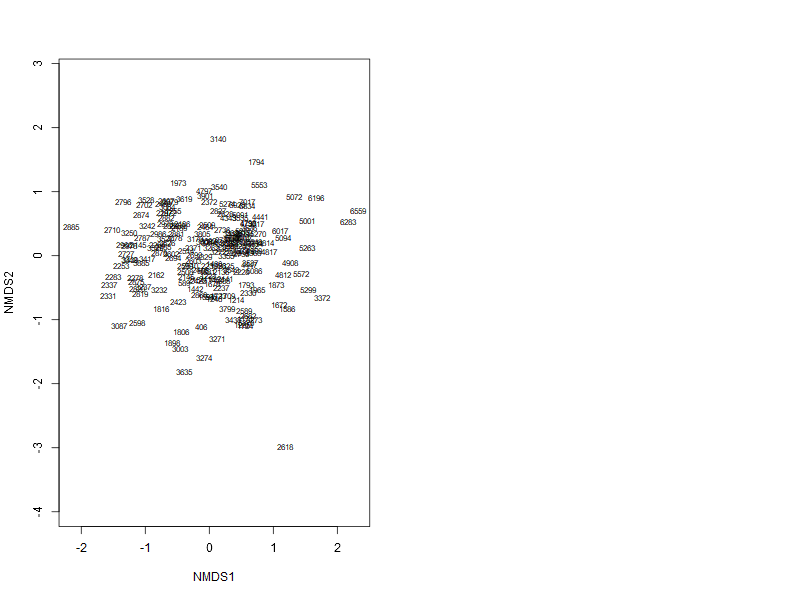

In [74]:

nmds_scores= monoMDS(stepacross(disimilarity), y = cmdscale(disimilarity, k=2),k = 2, model = "global", threshold = 0.8, maxit = 1000, 
                     
                     weakties = TRUE, stress = 1, scaling = TRUE, pc = TRUE, smin = 1e-4, sfgrmin = 1e-7, sratmax=0.99999) 


plot(nmds_scores)


With NMDS we caught the 0.917 variance of the disimilarities

In [75]:

stressplot(nmds_scores, cex.lab=0.8, cex.axis=0.8, cex.main=0.8, cex.sub=0.8) # se explicar un R = 91 total con dos ejes



In [76]:

scores_1= scores(nmds_scores$points)

scores_1= as.data.frame(scores_1)
head(scores_1)

            MDS1       MDS2
406  -0.12556643 -1.1112493
505  -0.09187334 -0.2367539
589  -0.39932082 -0.4204910
595   0.02248868 -0.6392807
1056  0.13574960 -0.1582332
1171  0.55223682 -0.9909010

## 3.3. Join NMDS to grids

In [77]:
grid_10km_elev["NMDS1"] = scores_1[,1]
grid_10km_elev["NMDS2"] = scores_1[,2]

grid_10km_elev

Simple feature collection with 198 features and 22 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -4.553896 xmax: -74.41422 ymax: 1.322877
Geodetic CRS:  WGS 84
First 10 features:
     id     left      top    right   bottom id_10km Ttl_rcr Totl_sp Smplg_c
1   406 504459.9  9886386 514459.9  9876386     406      74      33  0.7038
2   505 514459.9  9816386 524459.9  9806386     505     109      61  0.5975
3   589 524459.9  9896386 534459.9  9886386     589     402      81  0.8882
4   595 524459.9  9836386 534459.9  9826386     595      51      25  0.6298
5  1056 574459.9  9826386 584459.9  9816386    1056     116      26  0.8622
6  1171 584459.9  9596386 594459.9  9586386    1171      82      18  0.9274
7  1214 594459.9 10086386 604459.9 10076386    1214      69      23  0.7988
8  1223 594459.9  9996386 604459.9  9986386    1223     245      80  0.7881
9  1246 594459.9  9766386 604459.9  9756386    1246    1362      25  0.9912
10 1255 594459.9  9676

# 4. GAM - Beta diversity

In [78]:
df <- grid_10km_elev %>% st_drop_geometry()

# variables
df$NMDS1
df$NMDS2
df$elev_mean
df$centroid_x
df$centroid_y


## 4.1. Model - NMDS1

El modelo GAM ajustado para NMDS1 mostró un ajuste sólido y estadísticamente consistente, con un R² ajustado de 0.74 y una deviance explicada cercana al 77%, indicando que la elevación y la estructura espacial explican gran parte del gradiente ecológico representado por este eje. Ambos suavizadores fueron altamente significativos y sin señales de colinealidad, y los chequeos de bases confirmaron que la complejidad elegida fue suficiente sin sobreajuste. Los diagnósticos mostraron residuos aproximadamente normales, sin heterocedasticidad y sin patrones no capturados, mientras que el test de Moran evidenció ausencia de autocorrelación espacial residual. En conjunto, los supuestos del modelo se cumplen y los efectos estimados pueden interpretarse de manera confiable.

In [79]:
m_nmds1 <- gam(
  NMDS1 ~ 
    s(elev_mean) +                      # efecto no lineal de elevación
    s(centroid_x, centroid_y, bs = "tp"),             # suavizador espacial 2D
  data   = df,
  family = gaussian(),
  method = "REML"
)

summary(m_nmds1)


Family: gaussian 
Link function: identity 

Formula:
NMDS1 ~ s(elev_mean) + s(centroid_x, centroid_y, bs = "tp")

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -1.498e-17  3.069e-02       0        1

Approximate significance of smooth terms:
                           edf Ref.df      F p-value    
s(elev_mean)             5.672  6.804 31.945  <2e-16 ***
s(centroid_x,centroid_y) 5.818  8.201  7.628  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.689   Deviance explained = 70.7%
-REML = 131.86  Scale est. = 0.18646   n = 198

### 4.1.1. Checks


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-1.785358e-05,5.355439e-05]
(score 131.859 & scale 0.186457).
Hessian positive definite, eigenvalue range [0.191652,97.09402].
Model rank =  39 / 39 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                            k'   edf k-index p-value   
s(elev_mean)              9.00  5.67    1.21   1.000   
s(centroid_x,centroid_y) 29.00  5.82    0.87   0.005 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


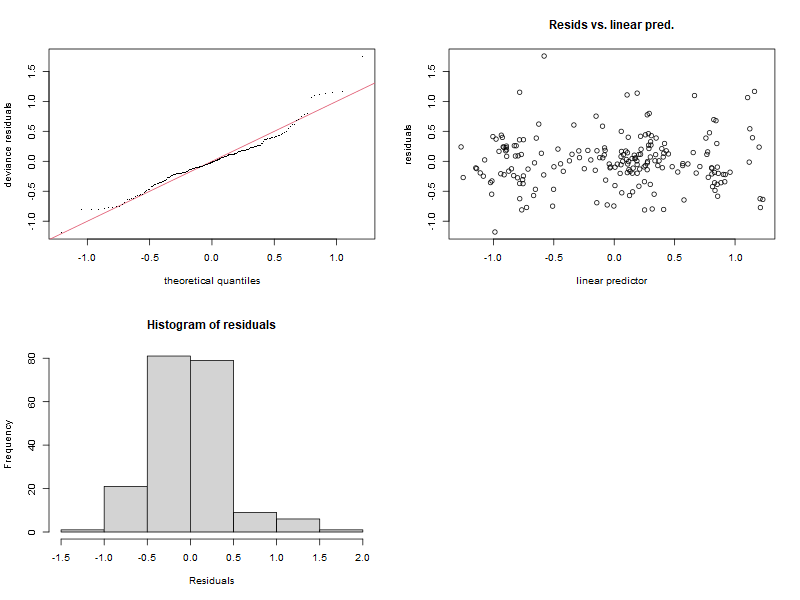

In [80]:
gam.check(m_nmds1)

### 4.1.2. Concurvity

In [81]:
concurvity(m_nmds1, full = TRUE)

                 para s(elev_mean) s(centroid_x,centroid_y)
worst    9.574507e-25    0.9361456                0.9361456
observed 9.574507e-25    0.8920703                0.2590132
estimate 9.574507e-25    0.7769693                0.1546138

### 4.1.3. Moran Test

In [82]:
library(spdep)

coords <- cbind(df$centroid_x, df$centroid_y)
nb_obj <- knn2nb(knearneigh(coords, k=5))
lw <- nb2listw(nb_obj)

moran.test(residuals(m_nmds1), lw)


	Moran I test under randomisation

data:  residuals(m_nmds1)  
weights: lw    

Moran I statistic standard deviate = 0.5775, p-value = 0.2818
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.018417841      -0.005076142       0.001655038 


### 4.1.4. Plot Predictions

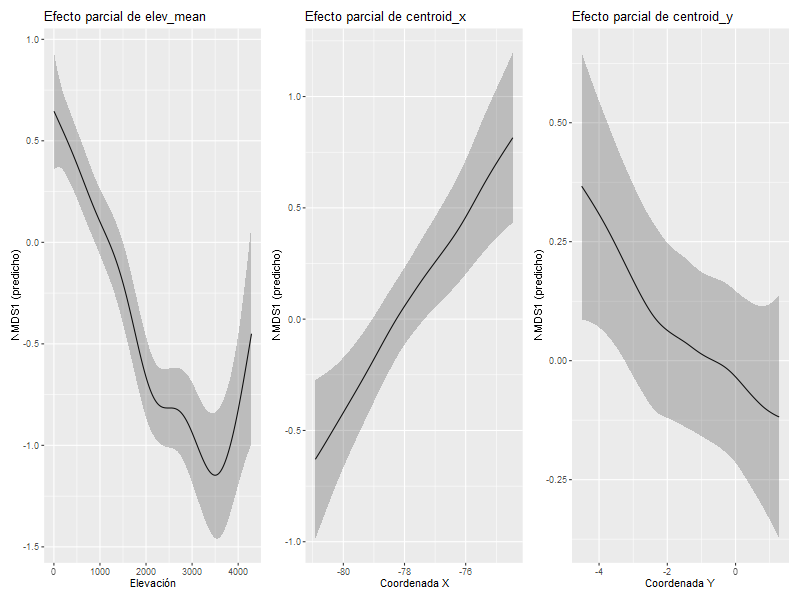

In [83]:
# ============================================================
# 1. Efecto parcial de elev_mean
# ============================================================

new_elev <- data.frame(
  elev_mean  = seq(min(df$elev_mean), max(df$elev_mean), length.out = 200),
  centroid_x = mean(df$centroid_x),
  centroid_y = mean(df$centroid_y)
)

p_elev <- predict(m_nmds1, newdata = new_elev, type = "response", se.fit = TRUE)

new_elev$fit   <- p_elev$fit
new_elev$lower <- p_elev$fit - 2*p_elev$se.fit
new_elev$upper <- p_elev$fit + 2*p_elev$se.fit

g1_nmds1_elev <- ggplot(new_elev, aes(elev_mean, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Elevación", y = "NMDS1 (predicho)") +
  ggtitle("Efecto parcial de elev_mean")


# ============================================================
# 2. Efecto parcial de centroid_x
# ============================================================

new_x <- data.frame(
  centroid_x = seq(min(df$centroid_x), max(df$centroid_x), length.out = 200),
  centroid_y = mean(df$centroid_y),
  elev_mean  = mean(df$elev_mean)
)

p_x <- predict(m_nmds1, newdata = new_x, type = "response", se.fit = TRUE)

new_x$fit   <- p_x$fit
new_x$lower <- p_x$fit - 2*p_x$se.fit
new_x$upper <- p_x$fit + 2*p_x$se.fit

g1_nmds1_x <- ggplot(new_x, aes(centroid_x, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Coordenada X", y = "NMDS1 (predicho)") +
  ggtitle("Efecto parcial de centroid_x")


# ============================================================
# 3. Efecto parcial de centroid_y
# ============================================================

new_y <- data.frame(
  centroid_y = seq(min(df$centroid_y), max(df$centroid_y), length.out = 200),
  centroid_x = mean(df$centroid_x),
  elev_mean  = mean(df$elev_mean)
)

p_y <- predict(m_nmds1, newdata = new_y, type = "response", se.fit = TRUE)

new_y$fit   <- p_y$fit
new_y$lower <- p_y$fit - 2*p_y$se.fit
new_y$upper <- p_y$fit + 2*p_y$se.fit

g1_nmds1_y <- ggplot(new_y, aes(centroid_y, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Coordenada Y", y = "NMDS1 (predicho)") +
  ggtitle("Efecto parcial de centroid_y")


# ============================================================
# 4. Figura final combinada
# ============================================================

(g1_nmds1_elev | g1_nmds1_x | g1_nmds1_y)


### 4.1.5. Predictions NMDS1

Reading layer `ecuador_limits' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\ecuador_limits.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.01115 ymin: -5.016157 xmax: -75.18715 ymax: 1.453982
Geodetic CRS:  WGS 84


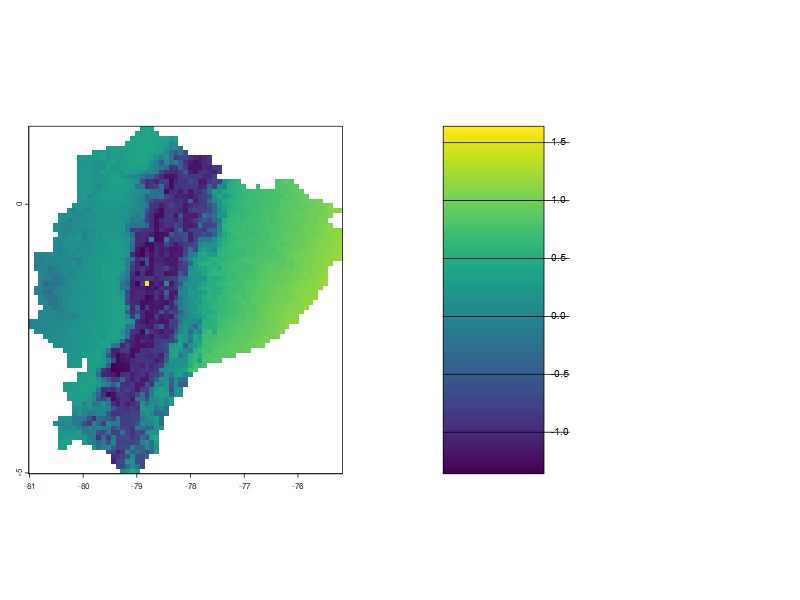

In [84]:
# =========================================================
# 1. Cargar límite de Ecuador y DEM en WGS84
# =========================================================

ecu <- st_read("Data/Shp/ecuador_limits.shp") |>
  st_transform(4326) |>
  st_make_valid()

ecu_v <- vect(ecu)

dem_30m <- rast("Data/raster/dem_30m.tif")
dem_30m <- project(dem_30m, "EPSG:4326")


# =========================================================
# 2. Crear raster vacío de 10 km cubriendo todo Ecuador
# =========================================================

ext_ecu <- ext(ecu_v)

# resolución equivalente a 10 km en grados
res_deg <- 10000 / 111320     # ≈ 0.089932°

r10 <- rast(
  extent = ext_ecu,
  resolution = res_deg,
  crs = "EPSG:4326",
  nlyrs = 1
)
names(r10) <- "NMDS1_pred"


# =========================================================
# 3. Extraer coordenadas de cada celda
# =========================================================

coords <- crds(r10, df = TRUE)
colnames(coords) <- c("centroid_x", "centroid_y")


# =========================================================
# 4. Extraer elevación desde DEM
# =========================================================

elev_df <- terra::extract(
  dem_30m,
  coords[, c("centroid_x", "centroid_y")]
)

df_pred <- cbind(coords, elev_mean = elev_df[,2])

# eliminar NA
df_pred <- df_pred[!is.na(df_pred$elev_mean), ]


# =========================================================
# 5. Predecir GAM NMDS1 en TODA LA ZONA
# =========================================================

pred_vals <- predict(
  m_nmds1,
  newdata = df_pred,
  type = "response"   # identidad → predicción = η
)

df_pred$pred <- pred_vals


# =========================================================
# 6. Insertar predicciones en raster
# =========================================================

r_pred <- r10

cell_ids <- cellFromXY(r_pred, df_pred[, c("centroid_x", "centroid_y")])

vals <- rep(NA, ncell(r_pred))
vals[cell_ids] <- df_pred$pred

r_pred_nmds1 <- setValues(r_pred, vals)


# =========================================================
# 7. Máscara para limitar SOLO Ecuador
# =========================================================

r_pred_ecu_nmds1 <- mask(r_pred_nmds1, ecu_v)

plot(r_pred_ecu_nmds1)

## 4.2. Model - NMDS2

El modelo GAM ajustado para NMDS2 mostró efectos significativos pero moderados de la elevación y de la estructura espacial, explicando aproximadamente un 31% de la variación del eje, un patrón esperado para un componente secundario del NMDS donde predomina variación ecológica más débil o ruidosa. Los diagnósticos del modelo indican un ajuste estable y apropiado: los residuos son aproximadamente normales, no presentan heterocedasticidad ni patrones sistemáticos frente al predictor lineal, y el análisis de Moran I confirma ausencia de autocorrelación espacial residual, lo que demuestra que el suavizador espacial absorbió adecuadamente la dependencia espacial existente. Asimismo, las pruebas de concurrvidad muestran niveles bajos tanto en los valores observados como en los que afectan a la estimación, indicando independencia adecuada entre los predictores y permitiendo interpretar sus efectos sin distorsión. En conjunto, el modelo es técnicamente sólido y cumple los supuestos, aunque su capacidad explicativa refleja que NMDS2 representa un gradiente ecológico más tenue que NMDS1.

In [85]:
m_nmds2 <- gam(
  NMDS2 ~ 
    s(elev_mean) +                      # efecto no lineal de elevación
    s(centroid_x, centroid_y, bs = "tp"),             # suavizador espacial 2D
  data   = df,
  family = gaussian(),
  method = "REML"
)

summary(m_nmds2)


Family: gaussian 
Link function: identity 

Formula:
NMDS2 ~ s(elev_mean) + s(centroid_x, centroid_y, bs = "tp")

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 4.495e-16  3.547e-02       0        1

Approximate significance of smooth terms:
                            edf Ref.df     F p-value    
s(elev_mean)              4.965  6.034 3.004  0.0077 ** 
s(centroid_x,centroid_y) 16.816 21.582 4.874  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.386   Deviance explained = 45.4%
-REML = 171.31  Scale est. = 0.24906   n = 198

### 4.2.1. Checks


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-2.790159e-09,-1.580043e-10]
(score 171.3126 & scale 0.2490627).
Hessian positive definite, eigenvalue range [0.9479705,97.62808].
Model rank =  39 / 39 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                            k'   edf k-index p-value
s(elev_mean)              9.00  4.97    1.08    0.88
s(centroid_x,centroid_y) 29.00 16.82    1.00    0.46


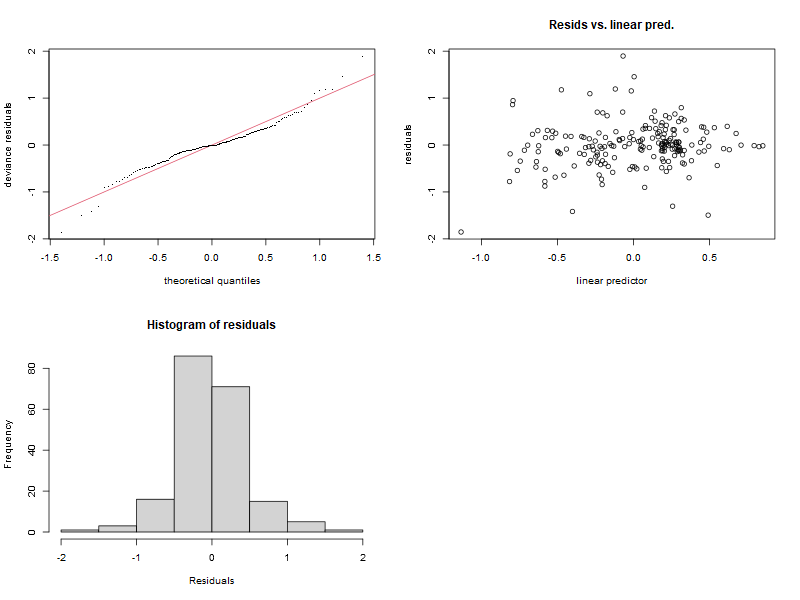

In [86]:
gam.check(m_nmds2)

### 4.2.2. Concurvity

In [87]:
concurvity(m_nmds2, full = TRUE)

                 para s(elev_mean) s(centroid_x,centroid_y)
worst    9.574507e-25    0.9361456                0.9361456
observed 9.574507e-25    0.2712862                0.1771669
estimate 9.574507e-25    0.7769693                0.1546138

### 4.2.3. Moran Test

In [88]:
library(spdep)

coords <- cbind(df$centroid_x, df$centroid_y)
nb_obj <- knn2nb(knearneigh(coords, k=5))
lw <- nb2listw(nb_obj)

moran.test(residuals(m_nmds2), lw)


	Moran I test under randomisation

data:  residuals(m_nmds2)  
weights: lw    

Moran I statistic standard deviate = -0.39707, p-value = 0.6543
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.021180841      -0.005076142       0.001644992 


### 4.2.4. Plot Predictions

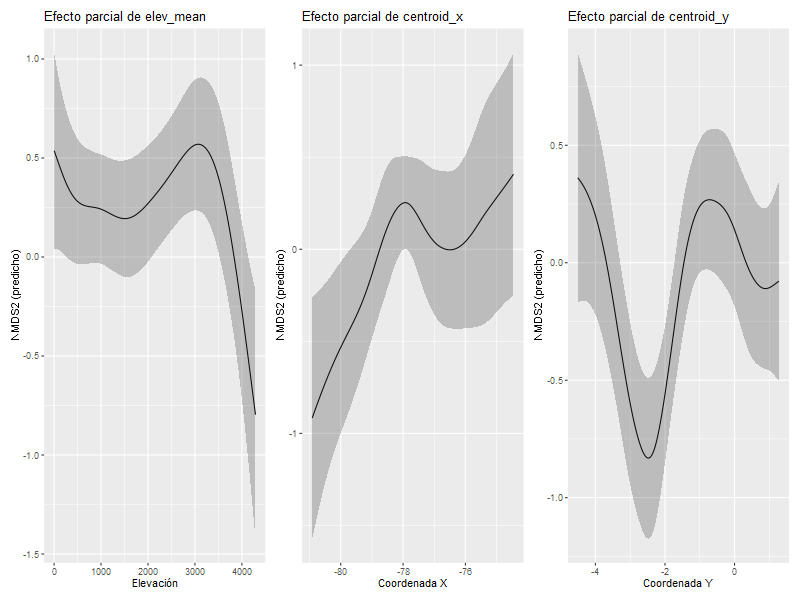

In [89]:
# ============================================================
# 1. Efecto parcial de elev_mean
# ============================================================

new_elev <- data.frame(
  elev_mean  = seq(min(df$elev_mean), max(df$elev_mean), length.out = 200),
  centroid_x = mean(df$centroid_x),
  centroid_y = mean(df$centroid_y)
)

p_elev <- predict(m_nmds2, newdata = new_elev, type = "response", se.fit = TRUE)

new_elev$fit   <- p_elev$fit
new_elev$lower <- p_elev$fit - 2*p_elev$se.fit
new_elev$upper <- p_elev$fit + 2*p_elev$se.fit

g1_nmds2_elev <- ggplot(new_elev, aes(elev_mean, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Elevación", y = "NMDS2 (predicho)") +
  ggtitle("Efecto parcial de elev_mean")


# ============================================================
# 2. Efecto parcial de centroid_x
# ============================================================

new_x <- data.frame(
  centroid_x = seq(min(df$centroid_x), max(df$centroid_x), length.out = 200),
  centroid_y = mean(df$centroid_y),
  elev_mean  = mean(df$elev_mean)
)

p_x <- predict(m_nmds2, newdata = new_x, type = "response", se.fit = TRUE)

new_x$fit   <- p_x$fit
new_x$lower <- p_x$fit - 2*p_x$se.fit
new_x$upper <- p_x$fit + 2*p_x$se.fit

g1_nmds2_x <- ggplot(new_x, aes(centroid_x, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Coordenada X", y = "NMDS2 (predicho)") +
  ggtitle("Efecto parcial de centroid_x")


# ============================================================
# 3. Efecto parcial de centroid_y
# ============================================================

new_y <- data.frame(
  centroid_y = seq(min(df$centroid_y), max(df$centroid_y), length.out = 200),
  centroid_x = mean(df$centroid_x),
  elev_mean  = mean(df$elev_mean)
)

p_y <- predict(m_nmds2, newdata = new_y, type = "response", se.fit = TRUE)

new_y$fit   <- p_y$fit
new_y$lower <- p_y$fit - 2*p_y$se.fit
new_y$upper <- p_y$fit + 2*p_y$se.fit

g1_nmds2_y <- ggplot(new_y, aes(centroid_y, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Coordenada Y", y = "NMDS2 (predicho)") +
  ggtitle("Efecto parcial de centroid_y")


# ============================================================
# 4. Figura final combinada
# ============================================================

(g1_nmds2_elev | g1_nmds2_x | g1_nmds2_y)


### 4.2.5. Predictions NMDS2

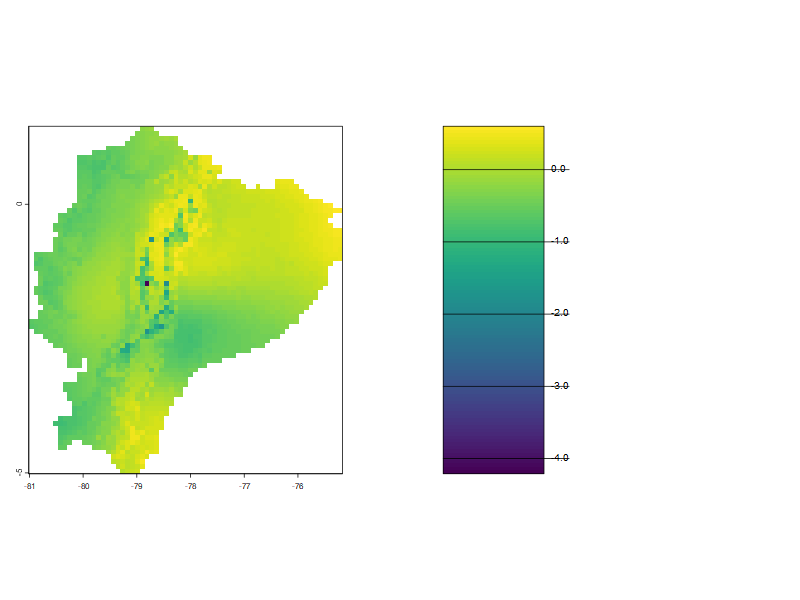

In [90]:

pred_vals <- predict(
  m_nmds2,
  newdata = df_pred,
  type = "response"   # identidad → predicción = η
)

df_pred$pred <- pred_vals


# =========================================================
# 6. Insertar predicciones en raster
# =========================================================

r_pred <- r10

cell_ids <- cellFromXY(r_pred, df_pred[, c("centroid_x", "centroid_y")])

vals <- rep(NA, ncell(r_pred))
vals[cell_ids] <- df_pred$pred

r_pred_nmds2 <- setValues(r_pred, vals)


# =========================================================
# 7. Máscara para limitar SOLO Ecuador
# =========================================================

r_pred_ecu_nmds2 <- mask(r_pred_nmds2, ecu_v)

plot(r_pred_ecu_nmds2)

# 5. Join  Bands

In [91]:
# Crear un stack con las dos capas NMDS1 y NMDS2
nmds_stack <- c(r_pred_ecu_nmds1, r_pred_ecu_nmds2)

nmds_stack

class       : SpatRaster 
dimensions  : 72, 65, 2  (nrow, ncol, nlyr)
resolution  : 0.08983112, 0.08983112  (x, y)
extent      : -81.01115, -75.17213, -5.016157, 1.451683  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source(s)   : memory
names       : NMDS1_pred, NMDS1_pred 
min values  :  -1.358951, -4.2119265 
max values  :   1.642269,  0.6021406 

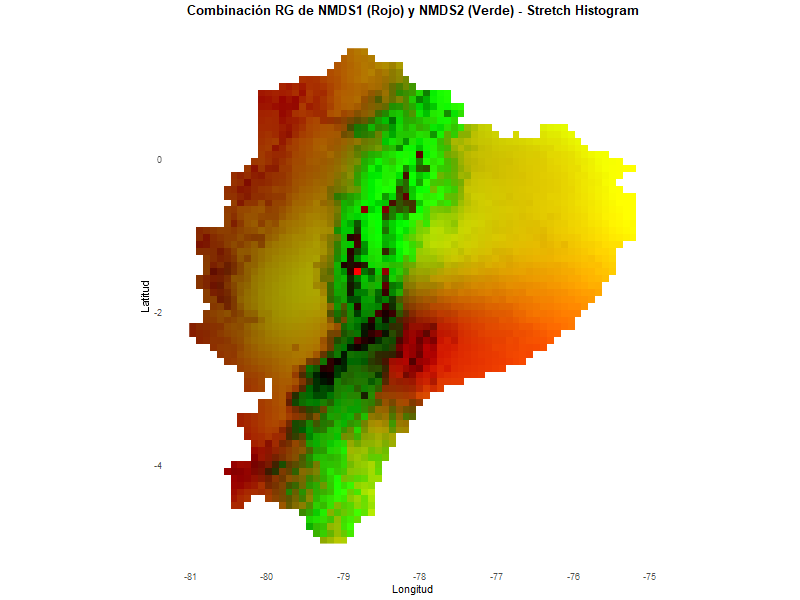

In [92]:


# Convertir de SpatRaster (terra) a RasterLayer (raster)
n1 <- raster(r_pred_ecu_nmds1)
n2 <- raster(r_pred_ecu_nmds2)

# Convertir a data frames con coordenadas
nmds_df1 <- as.data.frame(n1, xy = TRUE)
nmds_df2 <- as.data.frame(n2, xy = TRUE)

# Unir ambos data frames
df_nmds <- merge(nmds_df1, nmds_df2, by = c("x", "y"))
names(df_nmds) <- c("x", "y", "NMDS1", "NMDS2")

# Remover NAs
df_nmds <- na.omit(df_nmds)

# Stretch histogram - expande el contraste usando percentiles
hist_stretch <- function(x, percent = 0.02) {
  low <- quantile(x, percent, na.rm = TRUE)
  high <- quantile(x, 1 - percent, na.rm = TRUE)
  x[x < low] <- low
  x[x > high] <- high
  (x - low) / (high - low)
}

df_nmds$R <- hist_stretch(df_nmds$NMDS1)
df_nmds$G <- hist_stretch(df_nmds$NMDS2)

# Crear colores RGB
df_nmds$color <- rgb(df_nmds$R, df_nmds$G, 0)

# Plot con ggplot2
ggplot(df_nmds, aes(x = x, y = y)) +
  geom_raster(fill = df_nmds$color) +
  coord_equal() +
  labs(
    title = "Combinación RG de NMDS1 (Rojo) y NMDS2 (Verde) - Stretch Histogram",
    x = "Longitud",
    y = "Latitud"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    panel.grid = element_blank()
  )

# 6. Clúster Analysis

## 6.1. Get NMDS dataframe

In [93]:
# Extraer los valores del stack de NMDS1 y NMDS2
nmds_values <- getValues(stack(nmds_stack))
nmds_values <- na.omit(nmds_values)
head(nmds_values)

     NMDS1_pred.1 NMDS1_pred.2
[1,]    0.4064573   -0.2620280
[2,]    0.4182952   -0.2070969
[3,]    0.4162338   -0.1673736
[4,]    0.3988212   -0.3209631
[5,]    0.4069649   -0.2756716
[6,]    0.4150824   -0.2265371

## 6.2. Clústers K means

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 7 proposed 2 as the best number of clusters 
* 12 proposed 3 as the best number of clusters 
* 3 proposed 4 as the best number of clusters 
* 2 proposed 10 as the best number of clusters 

                   ***** Conclu

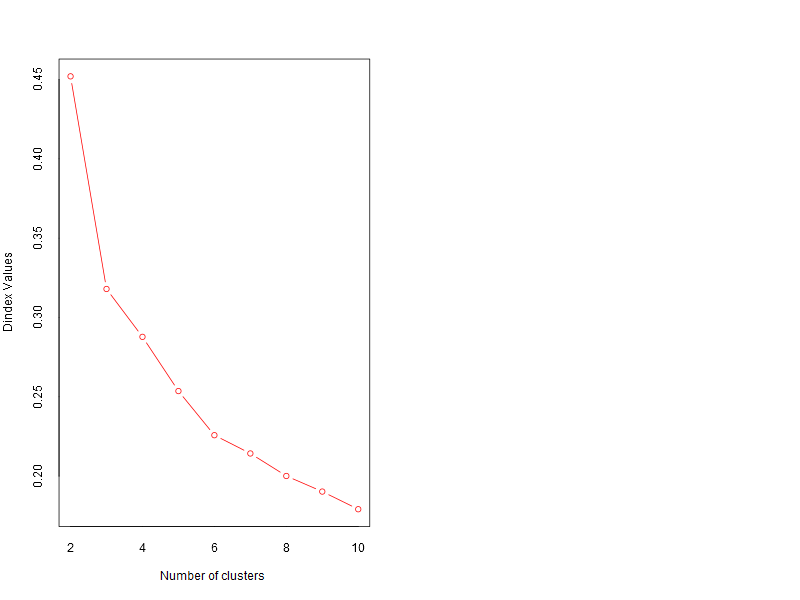

In [94]:

set.seed(593)
res_nb <- NbClust(nmds_values[, 1:2], distance = "euclidean",
                  min.nc = 2, max.nc = 10, method = "kmeans")

res_nb
     

## 6.3. Clúster Raster

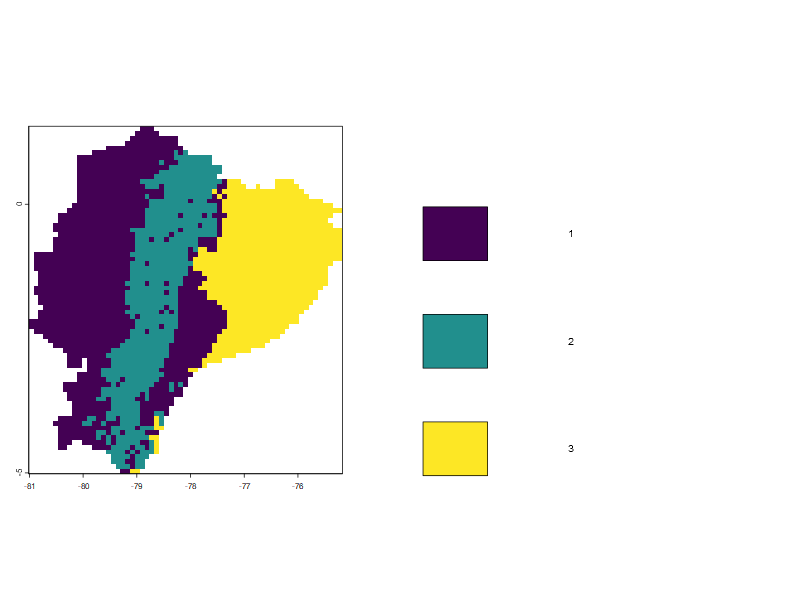

In [95]:

cluster_raster <- raster(stack(nmds_stack[[1]]))  # Usar la primera capa del stack para la plantilla
values(cluster_raster) <- NA  # Inicializar con NA
# Asignar los valores de los clusters al raster
cluster_raster[!is.na(getValues(stack(nmds_stack[[1]])))] <- res_nb$Best.partition
cluster_raster = rast(cluster_raster)
##plot cluster
plot(cluster_raster)

In [96]:
# Cargar tu stack NMDS como SpatRaster (ya lo tienes en nmds_stack)
# Crear raster de clusters como SpatRaster
cluster_raster <- rast(nmds_stack[[1]])
values(cluster_raster) <- NA

# Asignar la partición (vector res_nb$Best.partition) solo donde hay datos
vals <- values(nmds_stack[[1]])
cluster_raster[!is.na(vals)] <- res_nb$Best.partition

# Aplicar ventana focal 3x3 para obtener la moda
cluster_raster_clean <- focal(cluster_raster,
                    w = 3,
                    fun = modal,
                    na.policy = "omit",
                    na.rm = TRUE)

# Resultado final


In [97]:
plot(cluster_raster_clean)

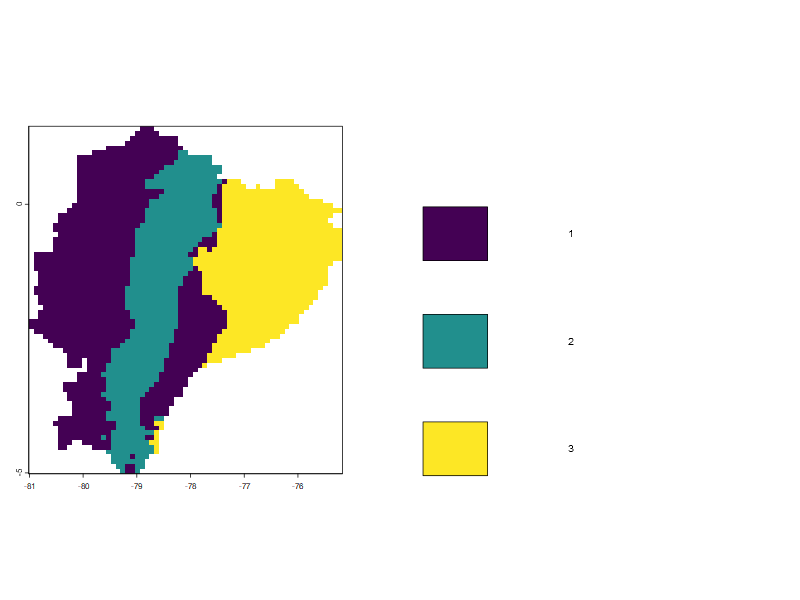

In [ ]:
plot(cluster_raster_clean)













# 7. Export results

In [98]:
writeRaster(nmds_stack, "Results/raster/nmds_result.tiff", overwrite=TRUE)
writeRaster(cluster_raster_clean, "Results/raster/cluster_raster_result.tiff", overwrite=TRUE)